# Broad Overview of the Execution of the Assignment

According to the ***Data Intern Assignment***, the main goal of the  analysis is to derive insights around if a fellow will ultimately be placed at a company and how long until a placement can be expected. 

To answer these questions I divide my analysis into two parts.

### First part

I focus on fitting a model which can predict which individuals who will get a job after the fellowship. Fot this part, I restrict the sample to individuals who have *pathrise_status* as *placed* or *Withdrawn (Failed)*  or for reasons described later in the notebook. I use logical reasoning, Pearson correlation  between variables and Chi-square test to select the important features. In this part of the analysis I start with analysing the Confusion Matrix, and the F1 score as evaluation metrics because the accuracy score do not make sense as a model evaluation criteria for imbalanced classes. To solve the issue of imbalanced classes, I use the oversampling technqiue. After searching through classification algorithms and parameter tuning, I find the optimal model to be a **RandomForestClassifier** with *min_samples_leaf = 1, min_samples_split = 4, n_estimators = 300* (using GridSearchCV). This gives me an *accuracy_score* of *0.9681274900398407* and *F1_Score* of *0.9663865546218486*


## Second Part
For the second part of the analysis, I want to be able to formulate a model to determine how long does it take a fellow to get a job. For this part I also restrict my sample to individuals who were placed and had *program_duration_days* less than 365 for reasons explained later in the notebook. I also do feature selection here based on logic, the correlation coefficients and chi-square test. However, for this part of the model, all my models give a negative R2 on the testing data. This means that the model cannot generalize well and I would not prescribe this model for prediction. I think that this is happening because the variables that we have are not at all a good predictor of the length of time it would take someone to get a job. This brings to my final point of recommendations.

## Recommendations

* Pathrise should collect some behavioral data from their fellows. I think that these kind of data might be more helpful in predicting how long it takes a fellow before he/she gets a job. For example, one fellow might have better interviewing skills than others, and this might help him/her land a job quicker. There are some estimates like *biggest_challenge_in_job_search* which are a good proxy but having more targeted behavioral questions might help.

* Second it might be helpful to have some indicators of the economic climate when the fellows are joining  as these might help us understand if the length of the time taken to get a job is an individual effect or a time fixed effect or even an interaction of the two. The *cohort_tag* variable could be thought of a proxy but in my analysis it does not help with the regression. More precisely measured variables about the economic climate could be very useful.

* One thing that was not clear to me was how is the job placement process after becoming a Pathrise fellow, in the sense that do fellows from the same cohort go into the job search process at the same time, and does everyone have access to the same number of interviews. If there is heterogeneity in these parameters, then I would say that I do not have the right data to answer the question of how long it would take a fellow to get a job. In such a scenario where there is difference in fellows in access to ex-post job interviews, a more pertinent question to ask would be why do some fellows get more interviews than others and then what is the correlation between getting interviews and getting placed.

### Start of analysis

In [655]:
#Importing packages
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,KFold
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

%matplotlib inline

In [485]:
#Reading the data
data = pd.read_csv("Pathrise.csv")



# First part of the analysis

To derive insights on whether a fellow will ultimately be placed at a company, I restrict the sample to appropriate fellows. I choose the individuals who have values eqaul to *Placed* or *Withdrawn (Failed)* for the **pathrise_status** field. This helps me get close to the problem, because these are the individuals who got a Pathrise fellowhsip, stayed through the program and whereas some people got placed, others did not. Restricting our analysis helps us best predict the model about whether an indivual conditional on getting a fellowship will eventually get a job or not. Thus our problem is a binary classification problem.

In [594]:
# Filtering the data based on the appropriate values of status
data_new = data[(data["pathrise_status"] == "Withdrawn (Failed)") | (data["pathrise_status"] == "Placed")]
data_new = data_new.dropna()
data_new.reset_index(drop=True, inplace=True)

In [595]:
#The number of rows has decreased from 2544 to 1038 as shown in the next line
print(data.shape)
print(data_new.shape)
data_new.head()

(2544, 16)
(538, 16)


,id,pathrise_status,primary_track,cohort_tag,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race
0,5,Placed,SWE,AUG19A,89.0,1,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American
1,8,Withdrawn (Failed),SWE,AUG19A,19.0,0,Employed Part-Time,Bachelor's Degree,Less than one month,Getting past final round interviews,1-2 years,Citizen,4.0,15,Female,Latino or Hispanic American
2,24,Placed,PSO,NOV19B,193.0,1,Unemployed,Master's Degree,6 months to a year,Hearing back on my applications,1-2 years,Citizen,5.0,4,Male,Non-Hispanic White or Euro-American
3,31,Placed,SWE,NOV19A,73.0,1,Student,Master's Degree,Less than one month,Figuring out which jobs to apply for,1-2 years,F1 Visa/CPT,0.0,1,Male,East Asian or Asian American
4,55,Placed,SWE,AUG19A,76.0,1,Student,Master's Degree,Less than one month,Getting past final round interviews,3-4 years,F1 Visa/OPT,0.0,30,Female,East Asian or Asian American


In [596]:
# Create the target feature which is the value of the *placed* column for our dataset
target = data_new["placed"]

#### Creating the feature dataset

The potential feature set includes all the columns apart from *pathrise_status*, *cohort_tag* and *program_duration_days*. *cohort_tag* is just a book-keeping data, and although it can have important fixed effects, it should not be used to predict the placement of a candidate as this is not an input feature of the candidate. Similarly, *program_duration_days* is an outcome of the fellowship at the intenstive margin and not an input feature to us. Pathrise won't have access to this data while predicting whether a potential fellow would get a job or not. Therefore, I do not use these variables in my feature set. Next, I also compute the Pearson correlation coefficients with numerical variables and chi-square test with categorical variables(as for most these variables there are more than 2 categories) to understand the relationship with categorical variables. 

                          placed  number_of_interviews  number_of_applications
placed                  1.000000              0.046794                0.056293
number_of_interviews    0.046794              1.000000                0.117736
number_of_applications  0.056293              0.117736                1.000000


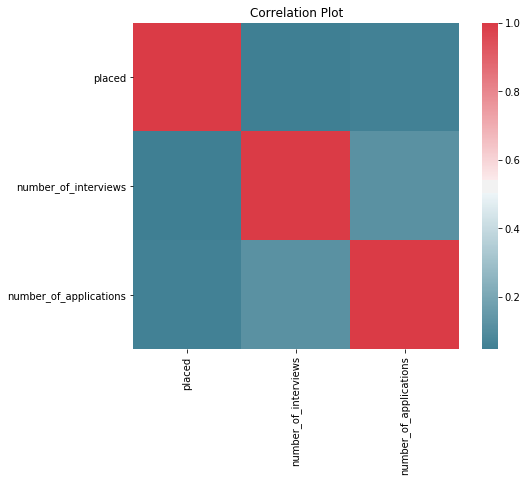

In [597]:
dat = data_new[[ "placed", "number_of_interviews", "number_of_applications", ]]

corr_df= dat  #New dataframe to calculate correlation between numeric features
cor= corr_df.corr(method='pearson')
print(cor)

fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

Since, there is no clear indication of data redundancy I include these variables in my features set.

In [598]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['primary_track']))
print("P-value: ",csq[1])

P-value:  0.3922732004080308


In [599]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['highest_level_of_education']))
print("P-value: ",csq[1])

P-value:  0.8106040902775794


In [600]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['employment_status ']))
print("P-value: ",csq[1])

P-value:  0.9991598767143844


In [601]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['biggest_challenge_in_search']))
print("P-value: ",csq[1])

P-value:  0.036772126064030713


In [602]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['professional_experience']))
print("P-value: ",csq[1])

P-value:  0.9319523312593513


In [603]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['work_authorization_status']))
print("P-value: ",csq[1])

P-value:  0.03179076164295807


In [604]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['length_of_job_search']))
print("P-value: ",csq[1])

P-value:  0.35642033115394584


P-value:  0.00018912132596735805


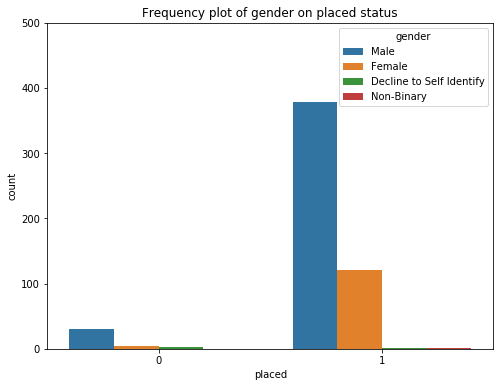

In [605]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['gender']))
print("P-value: ",csq[1])

fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='placed', data=data_new, hue='gender')
ax.set_ylim(0,500)
plt.title("Frequency plot of gender on placed status")
plt.show()

In [606]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new["race"]))
print("P-value: ",csq[1])

P-value:  0.6963677731892792


I create a feature datset with only the gender categorical variable and two continous variable and another feature dataset with all the variables because the p-value of all the categorical variables are very high, and hence there is no strong evidence of one variable having very high association

In [608]:
features_g = data_new[["number_of_interviews", "number_of_applications", "gender"]]

encoder = LabelEncoder()
for names in ["gender"]:
   features_g[names] = encoder.fit_transform(features_g[names].astype('str'))


C:\Users\shilp\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [609]:
features = data_new[["primary_track" ,"highest_level_of_education","employment_status ", "length_of_job_search", 
                    "biggest_challenge_in_search", "professional_experience", "work_authorization_status", 
                    "number_of_interviews", "number_of_applications", "gender", "race"]]

#Encoding categorical variables in the feature set
encoder = LabelEncoder()
for names in ["primary_track" ,"highest_level_of_education","employment_status ", "length_of_job_search", 
                    "biggest_challenge_in_search", "professional_experience", "work_authorization_status",
                     "gender", "race"]:
   features[names] = encoder.fit_transform(features[names].astype('str'))


C:\Users\shilp\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [610]:
# Splitting the training and testing data
features_g_train, features_g_test, labels_train, labels_test = train_test_split(features_g, target, test_size = 0.25, random_state = 42)
features_train, features_test, labels_train, labels_test = train_test_split(features, target, test_size = 0.25, random_state = 42)

Next I count the number of individuals who were placed in my datset and visualize it 

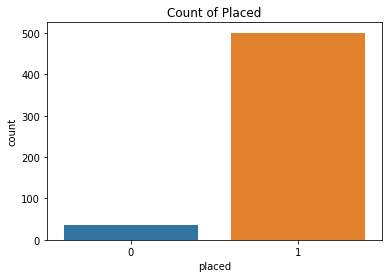

501


In [611]:
# Counting the number of individuals who were placed in our dataset

fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='placed', data=data_new)
plt.title("Count of Placed")
plt.show()


count = 0 
for i in data_new.placed:
    if i == 1:
        count += 1
print(count)


#### Problem of imbalanced classes

Since our problem is a binary classification problem, I count the number of individuals in each class to check whether the
data is balanced or not. As we can see out of the 538 indviduals in our dataset, 501 are of one class whereas only only 37 of 
second class. Running a machine learning model like this, will give us good accuracy scores, as well as F1 scores if we
consider placed == 1 to be the positive class because of the sheer magnitude of the number of individuals in that category. However, the confusion matrix is the ideal evaluation metric in this case, and as shown in the next cell block the confusion matrix on this data does not identify individuals who would not get a job. 

The next two cells show that for the both the features set we created earlier the confusion matrix gives very innacurate resulst, even though all other metrics such as accuracy_score, F1, recall and precision are very high. 

    

In [612]:
clf_g = DecisionTreeClassifier()
clf = DecisionTreeClassifier()
clf_g.fit(features_g_train, labels_train)
clf.fit(features_train, labels_train)
print("Feature set including only Gender")
print("Accuracy_score", accuracy_score(clf_g.predict(features_g_test), labels_test))
print("F1_Score", f1_score(clf_g.predict(features_g_test), labels_test))
print("Confusion Matrix\n", confusion_matrix(clf_g.predict(features_g_test), labels_test))
print("Precision_Score", precision_score(clf_g.predict(features_g_test), labels_test))
print("Recall_Score", recall_score(clf_g.predict(features_g_test), labels_test), "\n")
print("Feature set including all the features")
print("Accuracy_score", accuracy_score(clf.predict(features_test), labels_test))
print("F1_Score", f1_score(clf.predict(features_test), labels_test))
print("Confusion Matrix\n", confusion_matrix(clf.predict(features_test), labels_test))
print("Precision_Score", precision_score(clf.predict(features_test), labels_test))
print("Recall_Score", recall_score(clf.predict(features_test), labels_test))

Feature set including only Gender
Accuracy_score 0.8444444444444444
F1_Score 0.9156626506024096
Confusion Matrix
 [[  0   8]
 [ 13 114]]
Precision_Score 0.9344262295081968
Recall_Score 0.8976377952755905 

Feature set including all the features
Accuracy_score 0.8740740740740741
F1_Score 0.9328063241106719
Confusion Matrix
 [[  0   4]
 [ 13 118]]
Precision_Score 0.9672131147540983
Recall_Score 0.9007633587786259


In [613]:
clf_g = SVC()
clf = SVC()
clf_g.fit(features_g_train, labels_train)
clf.fit(features_train, labels_train)
print("Feature set including only Gender")
print("Accuracy_score", accuracy_score(clf_g.predict(features_g_test), labels_test))
print("F1_Score", f1_score(clf_g.predict(features_g_test), labels_test))
print("Confusion Matrix\n", confusion_matrix(clf_g.predict(features_g_test), labels_test))
print("Precision_Score", precision_score(clf_g.predict(features_g_test), labels_test))
print("Recall_Score", recall_score(clf_g.predict(features_g_test), labels_test), "\n")
print("Feature set including all the features")
print("Accuracy_score", accuracy_score(clf.predict(features_test), labels_test))
print("F1_Score", f1_score(clf.predict(features_test), labels_test))
print("Confusion Matrix\n", confusion_matrix(clf.predict(features_test), labels_test))
print("Precision_Score", precision_score(clf.predict(features_test), labels_test))
print("Recall_Score", recall_score(clf.predict(features_test), labels_test))

Feature set including only Gender
Accuracy_score 0.9037037037037037
F1_Score 0.9494163424124513
Confusion Matrix
 [[  0   0]
 [ 13 122]]
Precision_Score 1.0
Recall_Score 0.9037037037037037 

Feature set including all the features
Accuracy_score 0.9037037037037037
F1_Score 0.9494163424124513
Confusion Matrix
 [[  0   0]
 [ 13 122]]
Precision_Score 1.0
Recall_Score 0.9037037037037037


C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


As we can see that although the **Accuracy_Score**, **F1_Score**, **Precision_Score**, **Recall_Score** for both the *DecisionTreeClassifier* and *SVC* is very high, the confusion matrix shows that none of the individuals who were not placed were correctly identified. I tried a bunch of parameter tuning exercises not shown in this report, but that did little to improve the outcome. This is true for models for both the feature set. 

#### Oversampling

To solve the problem of skewed classes I use the technique of oversampling and radomly duplicate the observations in the minority class to equal the observations in the majority class. 

In [614]:
# Deivide the data into two classes
df_majority = data_new[data_new.placed==1]
df_minority = data_new[data_new.placed==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=501,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.placed.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64
data_new = y = df_upsampled  

data_new.shape
# As we can see the number of observations has increased from 538 to 1002, and now there are 501 observations of each class.

(1002, 16)

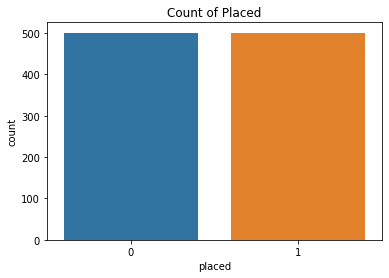

In [615]:
# Counting the number of individuals who were placed in this new modified dataset shows that minority class has been 
#artificially inflated to be equal to the minority class.

fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='placed', data=data_new)
plt.title("Count of Placed")
plt.show()



### Finding the correlation matrix for the new balanced dataset

                          placed  number_of_interviews  number_of_applications
placed                  1.000000              0.088908                0.100694
number_of_interviews    0.088908              1.000000                0.021850
number_of_applications  0.100694              0.021850                1.000000


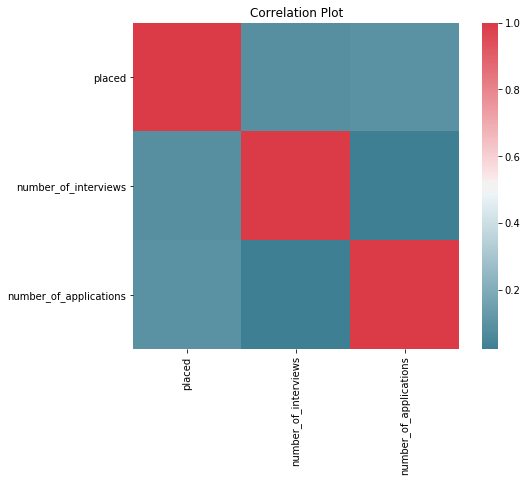

In [616]:
dat = data_new[[ "placed", "number_of_interviews", "number_of_applications", ]]


corr_df= dat  #New dataframe to calculate correlation between numeric features
cor= corr_df.corr(method='pearson')
print(cor)

fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

Since, the correlation coefficient is low for both the numerical features, I include both of them in my final feature set as there is no evidence of data redundancy.

### Performing the chi-square test for this new balanced dataset

P-value:  4.026661440933523e-14


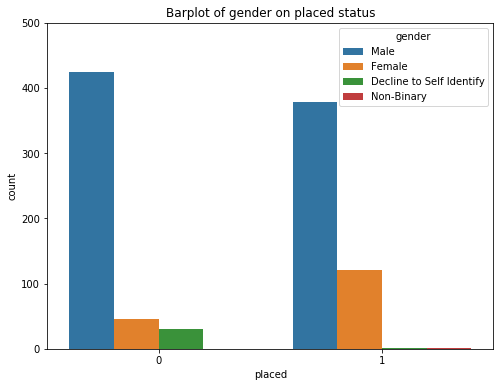

In [617]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['gender']))
print("P-value: ",csq[1])

fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='placed', data=data_new, hue='gender')
ax.set_ylim(0,500)
plt.title("Barplot of gender on placed status")
plt.show()

P-value:  1.0548290440395073e-05


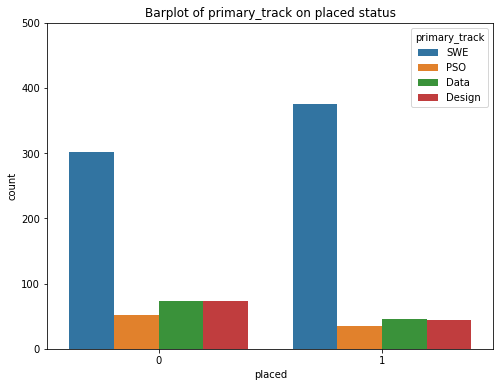

In [618]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['primary_track']))
print("P-value: ",csq[1])

fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='placed', data=data_new, hue='primary_track')
ax.set_ylim(0,500)
plt.title("Barplot of primary_track on placed status")
plt.show()

P-value:  1.5215783712340521e-06


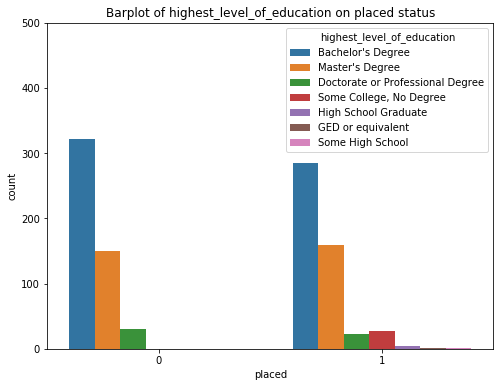

In [619]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['highest_level_of_education']))
print("P-value: ",csq[1])

fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='placed', data=data_new, hue='highest_level_of_education')
ax.set_ylim(0,500)
plt.title("Barplot of highest_level_of_education on placed status")
plt.show()

P-value:  0.3663329336092264


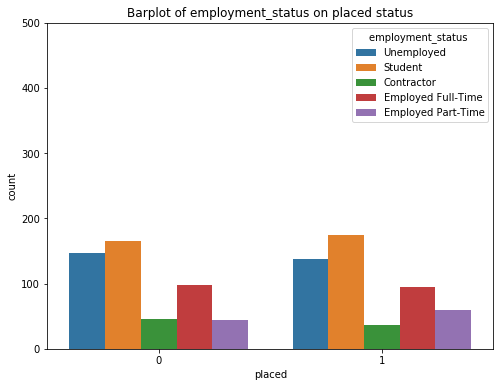

In [620]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['employment_status ']))
print("P-value: ",csq[1])

fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='placed', data=data_new, hue='employment_status ')
ax.set_ylim(0,500)
plt.title("Barplot of employment_status on placed status")
plt.show()

P-value:  1.0399990196170699e-08


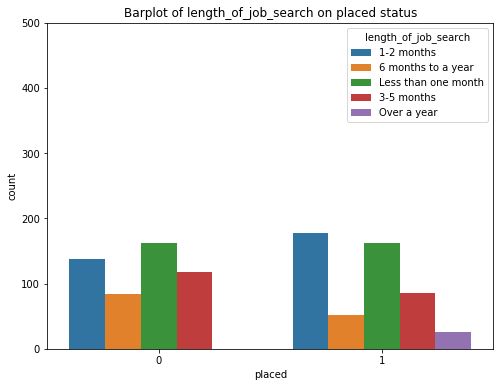

In [621]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['length_of_job_search']))
print("P-value: ",csq[1])

fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='placed', data=data_new, hue='length_of_job_search')
ax.set_ylim(0,500)
plt.title("Barplot of length_of_job_search on placed status")
plt.show()

P-value:  1.7000768984173891e-22


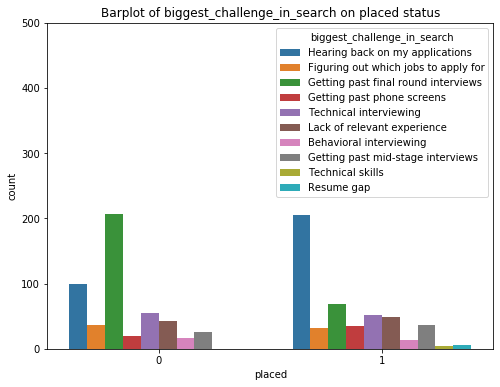

In [622]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['biggest_challenge_in_search']))
print("P-value: ",csq[1])

fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='placed', data=data_new, hue='biggest_challenge_in_search')
ax.set_ylim(0,500)
plt.title("Barplot of biggest_challenge_in_search on placed status")
plt.show()

P-value:  0.32946946354606965


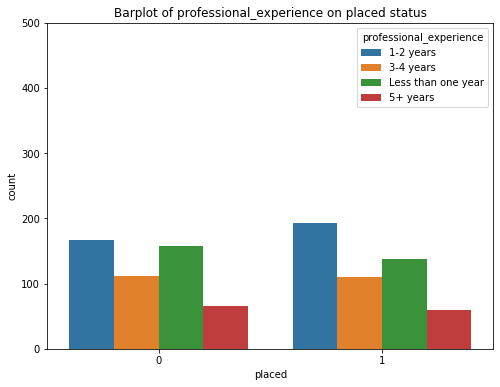

In [623]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['professional_experience']))
print("P-value: ",csq[1])

fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='placed', data=data_new, hue='professional_experience')
ax.set_ylim(0,500)
plt.title("Barplot of professional_experience on placed status")
plt.show()

P-value:  2.848362506917469e-10


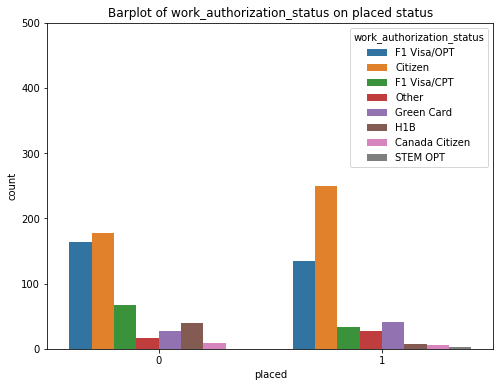

In [624]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['work_authorization_status']))
print("P-value: ",csq[1])

fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='placed', data=data_new, hue='work_authorization_status')
ax.set_ylim(0,500)
plt.title("Barplot of work_authorization_status on placed status")
plt.show()

P-value:  8.47034678765281e-05


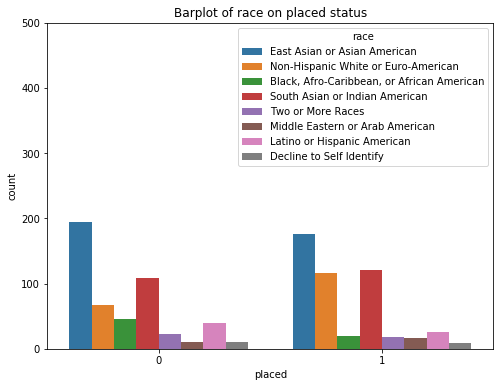

In [625]:
csq=chi2_contingency(pd.crosstab(data_new['placed'], data_new['race']))
print("P-value: ",csq[1])

fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='placed', data=data_new, hue='race')
ax.set_ylim(0,500)
plt.title("Barplot of race on placed status")
plt.show()

For the categorical variables, apart from *professional_experinece* and *employment_status* all the variables have very low p - values which suggest that they have relationship with the target variable and hence we will be using all the other categorical variables.

#### Redefining the features set, target set, and testing and training data on the new oversampled data

In [627]:
target = data_new["placed"]

features = data_new[["primary_track" ,"highest_level_of_education", "length_of_job_search", 
                    "biggest_challenge_in_search",  "work_authorization_status", 
                    "number_of_interviews", "number_of_applications", "gender", "race"]]

#Encoding categorical variables in the feature set
encoder = LabelEncoder()
for names in ["primary_track" ,"highest_level_of_education", "length_of_job_search", 
                    "biggest_challenge_in_search", "work_authorization_status",
                     "gender", "race"]:
   features[names] = encoder.fit_transform(features[names].astype('str'))

# Splitting the training and testing data
features_train, features_test, labels_train, labels_test = train_test_split(features, target, 
                                                                            test_size = 0.25, random_state = 42)



C:\Users\shilp\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


After creating my new features and target from my new oversampled data, I run various classification algorithms such as  **Random Forest Classifier**, **Gaussian Naive Bayes**, **Logistic Regression** and **Support Vector Machine**. Out of these algorithms **Support Vector Machine(SVM)**, and **Random Forest Classifier** seem to perform well as shown in the next few codes. **Logistic Regression** and **Gaussian NB** do not seem to perform well in this case. I use f1_score on a 10 fold cross validation to determine the efficiency of my model

In [628]:
clf = RandomForestClassifier()
clf.fit(features_train, labels_train)
print("F1_Score", f1_score(clf.predict(features_test), labels_test))
print("Confusion Matrix", confusion_matrix(clf.predict(features_test), labels_test))
print("Precision_Score", precision_score(clf.predict(features_test), labels_test))
print("Recall_Score", recall_score(clf.predict(features_test), labels_test))
scores = cross_val_score(clf, features, target, cv = 10, scoring = 'f1')
np.mean(scores)

F1_Score 0.9576271186440678
Confusion Matrix [[128  10]
 [  0 113]]
Precision_Score 0.9186991869918699
Recall_Score 1.0


C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9742877438385538

In [629]:
clf = SVC()
clf.fit(features_train, labels_train)
print("F1_Score", f1_score(clf.predict(features_test), labels_test))
print("Confusion Matrix", confusion_matrix(clf.predict(features_train), labels_train))
print("Confusion Matrix", confusion_matrix(clf.predict(features_test), labels_test))
print("Precision_Score", precision_score(clf.predict(features_test), labels_test))
print("Recall_Score", recall_score(clf.predict(features_test), labels_test))
scores = cross_val_score(clf, features, target, cv = 10, scoring = 'f1')
np.mean(scores)


C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

F1_Score 0.9959183673469388
Confusion Matrix [[373   0]
 [  0 378]]
Confusion Matrix [[128   1]
 [  0 122]]
Precision_Score 0.991869918699187
Recall_Score 1.0


C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9918560991382117

In [630]:
clf = LogisticRegression()
clf.fit(features_train, labels_train)
print("F1_Score", f1_score(clf.predict(features_test), labels_test))
print("Confusion Matrix", confusion_matrix(clf.predict(features_train), labels_train))
print("Confusion Matrix", confusion_matrix(clf.predict(features_test), labels_test))
print("Precision_Score", precision_score(clf.predict(features_test), labels_test))
print("Recall_Score", recall_score(clf.predict(features_test), labels_test))
scores = cross_val_score(clf, features, target, cv = 10, scoring = 'f1')
np.mean(scores)

F1_Score 0.5887096774193549
Confusion Matrix [[227 136]
 [146 242]]
Confusion Matrix [[76 50]
 [52 73]]
Precision_Score 0.5934959349593496
Recall_Score 0.584


C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

0.6119052014905134

In [631]:
clf = GaussianNB()
clf.fit(features_train, labels_train)
print("F1_Score", f1_score(clf.predict(features_test), labels_test))
print("Confusion Matrix", confusion_matrix(clf.predict(features_train), labels_train))
print("Confusion Matrix", confusion_matrix(clf.predict(features_test), labels_test))
print("Precision_Score", precision_score(clf.predict(features_test), labels_test))
print("Recall_Score", recall_score(clf.predict(features_test), labels_test))
scores = cross_val_score(clf, features, target, cv = 10, scoring = 'f1')
np.mean(scores)

F1_Score 0.5753424657534246
Confusion Matrix [[280 176]
 [ 93 202]]
Confusion Matrix [[95 60]
 [33 63]]
Precision_Score 0.5121951219512195
Recall_Score 0.65625


0.5852884904619271

As we can see that the **SupportVectorClassifier**  and the **RandomForestClassifier** performs relatively well with a *F1_score* of *0.9918560991382117* and 0.*9742877438385538* respectively on a 10 fold cross validation test. The next ideal step would be to do a grid search based on cross-validation based on these algorithms. 

In [664]:
parameter_candidates = [ 
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

fone_scorer = make_scorer(fbeta_score, beta=1)

# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=SVC(), param_grid=parameter_candidates,  scoring = fone_scorer, cv = 10)

# Train the classifier on data1's feature and target data
clf.fit(features_train, labels_train) 

# View the best F1_one score
print('Best score for data1:', clf.best_score_) 
# cv_results = clf.cv_results_
# print(cv_results)
print("Best parameters from gridsearch: {}".format(clf.best_params_))

Best score for data1: 0.8424226560844974
Best parameters from gridsearch: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [531]:
parameter_candidates = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 4, 6, 8, 9, 10],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}


fone_scorer = make_scorer(fbeta_score, beta=1)

clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameter_candidates, n_jobs=-1, scoring = fone_scorer, cv = 10)

# Train the classifier on data1's feature and target data
clf.fit(features_train, labels_train) 

# View the best F1_one score
print('Best score for data1:', clf.best_score_) 
# cv_results = clf.cv_results_
# print(cv_results)
print("Best parameters from gridsearch: {}".format(clf.best_params_))

Best score for data1: 0.9823998432520404
Best parameters from gridsearch: {'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}


As we can see we that after performimg the GridSearchCV on the **Support Vector Classifier** and **Random Forest Classifier**, the latter gives better performance with the following parameters. Best parameters from gridsearch: {'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}. Next I run this model with the following parameters on the testing set to and then train the model on the entire data to create the most efficient model.

In [588]:
clf = RandomForestClassifier(min_samples_leaf = 1, min_samples_split = 4, n_estimators = 300, random_state = 42)
clf.fit(features_train, labels_train)
print("Accuracy_Score", accuracy_score(clf.predict(features_test), labels_test) )
print("F1_Score", f1_score(clf.predict(features_test), labels_test))
print("Confusion Matrix", confusion_matrix(clf.predict(features_test), labels_test))
print("Precision_Score", precision_score(clf.predict(features_test), labels_test))
print("Recall_Score", recall_score(clf.predict(features_test), labels_test))

Accuracy_Score 0.9681274900398407
F1_Score 0.9663865546218486
Confusion Matrix [[128   8]
 [  0 115]]
Precision_Score 0.9349593495934959
Recall_Score 1.0


Finally I train my model on the entire dataset

In [537]:
clf = RandomForestClassifier(min_samples_leaf = 1, min_samples_split = 4, n_estimators = 300, random_state = 42)
clf.fit(features, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### Second Part of the Analysis

For the second part, we want to know how long does it take a fellow to take a job. For this part of the analysis, we only look at the individuals who have been placed by the Pathrise fellowship because we want to see the effect of the fellowship at the intensive margin.

In [550]:
# Filtering the data based on the appropriate values of status
data_int = data[(data["pathrise_status"] == "Placed") ]
data_int.reset_index(drop=True, inplace=True)

In this case the target variable is the *program_duration_days*. We again compute the correlation matrix and perform the chi-squared test to understand which features to include in the data

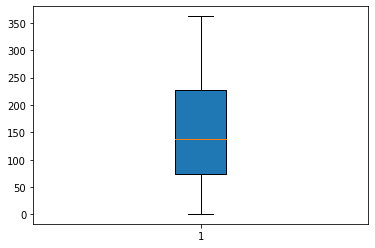

In [567]:
# Create the target feature which is the value of the *placed* column for our dataset
target_int = data_int["program_duration_days"]

plt.boxplot(target_int, patch_artist=True)
ax.set_xticklabels(['Sample1'])
plt.show()
target.reset_index(drop=True, inplace=True)

Since, according to the assignment the program lasts only for one year including the core curriculum, the entries which are above 365 must be of people who had taken a break and later resumed fellowship. Since, I do not have information on people who took a break, I slice the data to individuals who have *program_duration_days* less than 365. This helps me restrict my sample to the appropriate individuals

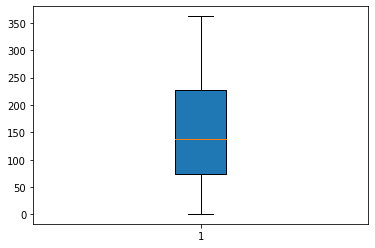

(491, 16)


In [568]:
# I therefore redefine the data_int and target_int
data_int = data[(data["pathrise_status"] == "Placed" ) & (data["program_duration_days"] <= 365)]

data_int = data_int.dropna()

target_int = data_int["program_duration_days"]

plt.boxplot(target_int, patch_artist=True)
ax.set_xticklabels(['Sample1'])
plt.show()
print(data_int.shape)

                        program_duration_days  number_of_interviews  \
program_duration_days                1.000000             -0.099993   
number_of_interviews                -0.099993              1.000000   
number_of_applications              -0.033437              0.131901   

                        number_of_applications  
program_duration_days                -0.033437  
number_of_interviews                  0.131901  
number_of_applications                1.000000  


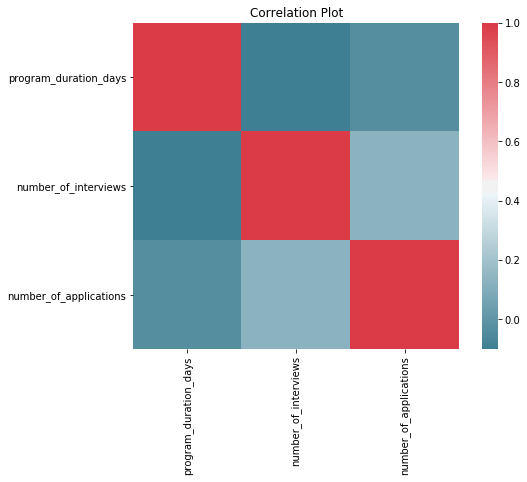

In [569]:
dat = data_int[[ "program_duration_days", "number_of_interviews", "number_of_applications", ]]

corr_df= dat  #New dataframe to calculate correlation between numeric features
cor= corr_df.corr(method='pearson')
print(cor)

fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

Since there is no clear pattern here, I include both the variables in my regression.

P-value:  2.638412190802648e-06


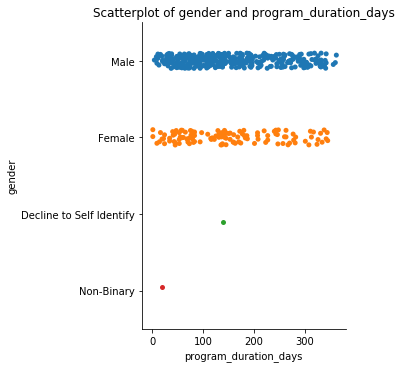

In [632]:
csq=chi2_contingency(pd.crosstab(data_int['program_duration_days'], data_int['gender']))
print("P-value: ",csq[1])

sns.catplot(y="gender", x="program_duration_days", data=data_int)
plt.title("Scatterplot of gender and program_duration_days");


P-value:  0.14051011657442514


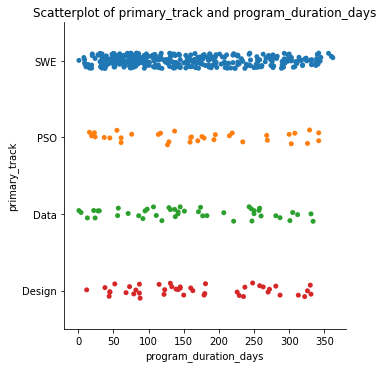

In [633]:
csq=chi2_contingency(pd.crosstab(data_int['program_duration_days'], data_int['primary_track']))
print("P-value: ",csq[1])

sns.catplot(y="primary_track", x="program_duration_days", data=data_int)
plt.title("Scatterplot of primary_track and program_duration_days");

P-value:  0.004540144781461475


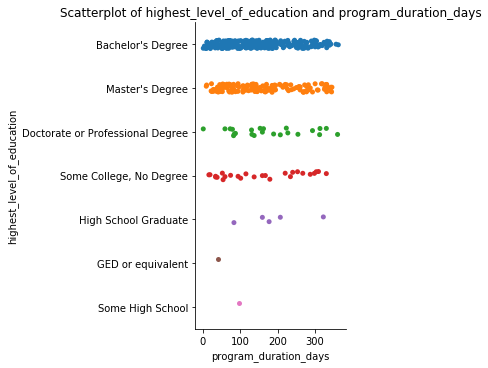

In [634]:
csq=chi2_contingency(pd.crosstab(data_int['program_duration_days'], data_int['highest_level_of_education']))
print("P-value: ",csq[1])

sns.catplot(y="highest_level_of_education", x="program_duration_days", data=data_int);
plt.title("Scatterplot of highest_level_of_education and program_duration_days");

P-value:  0.483003449478191


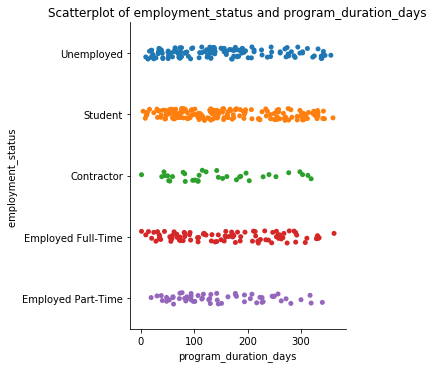

In [635]:
csq=chi2_contingency(pd.crosstab(data_int['program_duration_days'], data_int['employment_status ']))
print("P-value: ",csq[1])

sns.catplot(y="employment_status ", x="program_duration_days", data=data_int);
plt.title("Scatterplot of employment_status and program_duration_days");

P-value:  0.11159653334799276


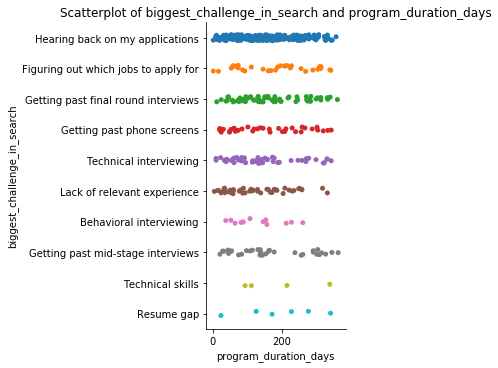

In [636]:
csq=chi2_contingency(pd.crosstab(data_int['program_duration_days'], data_int['biggest_challenge_in_search']))
print("P-value: ",csq[1])

sns.catplot(y="biggest_challenge_in_search", x="program_duration_days", data=data_int);
plt.title("Scatterplot of biggest_challenge_in_search and program_duration_days");

P-value:  2.5021968188096178e-116


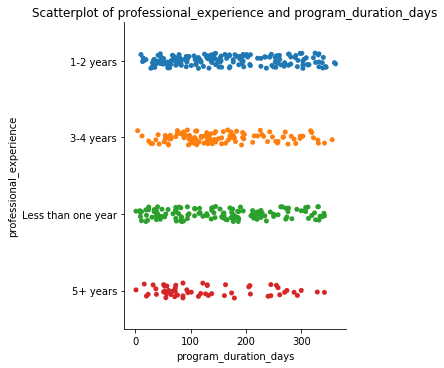

In [637]:
csq=chi2_contingency(pd.crosstab(data_new['program_duration_days'], data_new['professional_experience']))
print("P-value: ",csq[1])

sns.catplot(y="professional_experience", x="program_duration_days", data=data_int);
plt.title("Scatterplot of professional_experience and program_duration_days");

P-value:  2.0706845539168156e-242


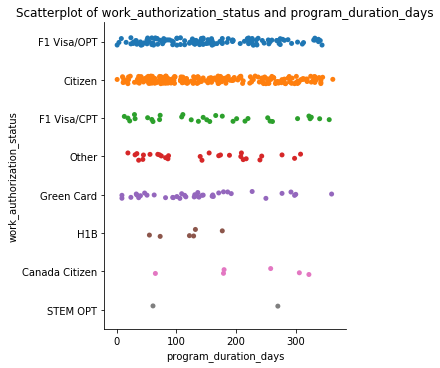

In [638]:
csq=chi2_contingency(pd.crosstab(data_new['program_duration_days'], data_new['work_authorization_status']))
print("P-value: ",csq[1])

sns.catplot(y="work_authorization_status", x="program_duration_days", data=data_int);
plt.title("Scatterplot of work_authorization_status and program_duration_days");

P-value:  5.199763425667946e-121


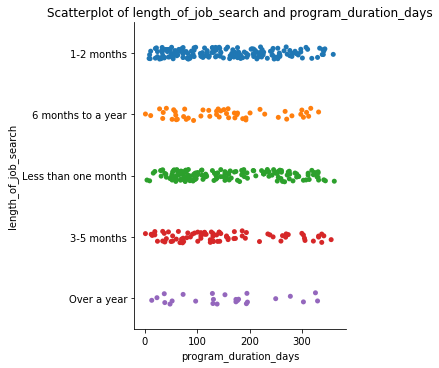

In [639]:
csq=chi2_contingency(pd.crosstab(data_new['program_duration_days'], data_new['length_of_job_search']))
print("P-value: ",csq[1])

sns.catplot(y="length_of_job_search", x="program_duration_days", data=data_int);
plt.title("Scatterplot of length_of_job_search and program_duration_days");

Going by the p -values I do not include the following variables *primary_track*, *biggest_challenge_in_search* and *employment_status* as a part of my features. 

In [640]:
features = data_int[["highest_level_of_education", "length_of_job_search", 
                     "work_authorization_status", "professional_experience",
                    "number_of_interviews", "number_of_applications", "gender", "race", "cohort_tag"]]

#Encoding categorical variables in the feature set
encoder = LabelEncoder()
for names in ["highest_level_of_education", "length_of_job_search",
              "work_authorization_status", "professional_experience",
                     "gender", "race", "cohort_tag"]:
   features[names] = encoder.fit_transform(features[names].astype('str'))

# Splitting the training and testing data
X_train, X_test, y_train, y_test = train_test_split(features, target_int, 
                                                                            test_size = 0.5, random_state = 49)

C:\Users\shilp\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


For the regression problem, I try a number of different regression algorithms such as **Linear Regression**, **Lasso Regression**, **Support Vector Regressorion** **Random Forest Regression**, **Polynomial Regression**, **Ridge Regression** and **ElasticNet** . In all these regressors, although the R2 for the training data is high, the R2 for the test data is negative. This means that the mean value does a better job at predicting the outcome than our model. Even after parameter tuning on all the algorithms(not shown for brevity) the R2 is negative for test data and cross-validation exercises.

In [658]:
reg = RandomForestRegressor()
reg.fit(X_train, y_train)
print("R2 on training data", reg.score(X_train, y_train))
print("R2 on test data", reg.score(X_test, y_test))
print("MAE", mean_absolute_error(y_test, reg.predict(X_test)))
print("MSE", mean_squared_error(y_test, reg.predict(X_test)))
print("RMSE", math.sqrt(mean_squared_error(y_test, reg.predict(X_test))))

scores_1 = cross_val_score(reg, features, target_int, cv = 10, scoring = 'neg_mean_squared_error')
scores_2 = cross_val_score(reg, features, target_int, cv = 10, scoring = 'r2')
print("MSE on cross validated data", np.mean(scores_1))
print("R2 on cross validated data", np.mean(scores_2))

C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2 on training data 0.7419087943435074
R2 on test data -0.28469800760392827
MAE 86.06626016260164
MSE 11498.71231707317
RMSE 107.2320489269564
MSE on cross validated data -10092.65617102041
R2 on cross validated data -0.37532188919601506


I have also tried the **RandomForestRegressor** using other parameters and it always gives a negative R2 for testing set.

In [659]:
reg = SVR()
reg.fit(X_train, y_train)
print("R2 on training data", reg.score(X_train, y_train))
print("R2 on test data", reg.score(X_test, y_test))
print("MAE", mean_absolute_error(y_test, reg.predict(X_test)))
print("MSE", mean_squared_error(y_test, reg.predict(X_test)))
print("RMSE", math.sqrt(mean_squared_error(y_test, reg.predict(X_test))))

scores_1 = cross_val_score(reg, features, target_int, cv = 10, scoring = 'neg_mean_squared_error')
scores_2 = cross_val_score(reg, features, target_int, cv = 10, scoring = 'r2')
print("MSE on cross validated data", np.mean(scores_1))
print("R2 on cross validated data", np.mean(scores_2))

C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

R2 on training data -0.0019180677832615345
R2 on test data -0.015119936892986852
MAE 79.09189465347602
MSE 9085.849010872425
RMSE 95.31971994751362
MSE on cross validated data -9349.906591179772
R2 on cross validated data -0.17081848370080677


C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\shilp\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

In [660]:
reg = Lasso(alpha=0.1)
reg.fit(X_train, y_train)
print("R2 on training data", reg.score(X_train, y_train))
print("R2 on test data", reg.score(X_test, y_test))
print("MAE", mean_absolute_error(y_test, reg.predict(X_test)))
print("MSE", mean_squared_error(y_test, reg.predict(X_test)))
print("RMSE", math.sqrt(mean_squared_error(y_test, reg.predict(X_test))))

scores_1 = cross_val_score(reg, features, target_int, cv = 10, scoring = 'neg_mean_squared_error')
scores_2 = cross_val_score(reg, features, target_int, cv = 10, scoring = 'r2')
print("MSE on cross validated data", np.mean(scores_1))
print("R2 on cross validated data", np.mean(scores_2))

R2 on training data 0.07465379424883822
R2 on test data -0.08682439699503752
MAE 82.12335439611995
MSE 9727.641053581601
RMSE 98.62880438077713
MSE on cross validated data -9168.092881774824
R2 on cross validated data -0.1697978531442894


In [661]:
poly = PolynomialFeatures(2)
poly_features = poly.fit_transform(features)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test)
poly_model = LinearRegression(fit_intercept=False)
poly_model.fit(X_poly_train, y_train)
print("R2 on training data", poly_model.score(X_poly_train, y_train))
print("R2 on training data", poly_model.score(X_poly_test, y_test))
print("MAE", mean_absolute_error(y_test, poly_model.predict(X_poly_test)))
print("MSE", mean_squared_error(y_test, poly_model.predict(X_poly_test)))
print("RMSE", math.sqrt(mean_squared_error(y_test, poly_model.predict(X_poly_test))))
scores_1 = cross_val_score(poly_model, poly_features, target_int, cv = 10, scoring = 'neg_mean_squared_error')
scores_2 = cross_val_score(poly_model, poly_features, target_int, cv = 10, scoring = 'r2')
print("MSE on cross validated data", np.mean(scores_1))
print("R2 on cross validated data", np.mean(scores_2))

R2 on training data 0.24460929417880772
R2 on training data -0.3329762754848984
MAE 89.83983523796745
MSE 11930.827810554201
RMSE 109.22832879136347
MSE on cross validated data -10373.679244718816
R2 on cross validated data -0.34167728274228776


In [662]:
# Train model with default alpha=1
reg = Ridge(alpha = 1)
reg.fit(X_train, y_train)
print("R2 on training data", reg.score(X_train, y_train))
print("R2 on test data", reg.score(X_test, y_test))
print("MAE", mean_absolute_error(y_test, reg.predict(X_test)))
print("MSE", mean_squared_error(y_test, reg.predict(X_test)))
print("RMSE", math.sqrt(mean_squared_error(y_test, reg.predict(X_test))))

scores_1 = cross_val_score(reg, features, target_int, cv = 10, scoring = 'neg_mean_squared_error')
scores_2 = cross_val_score(reg, features, target_int, cv = 10, scoring = 'r2')
print("MSE on cross validated data", np.mean(scores_1))
print("R2 on cross validated data", np.mean(scores_2))

R2 on training data 0.07466262175050897
R2 on test data -0.08742220523529953
MAE 82.13612665395247
MSE 9732.991746845591
RMSE 98.65592606045311
MSE on cross validated data -9170.380305848656
R2 on cross validated data -0.1700928279101278


In [663]:
# Train model with default alpha=1 and l1_ratio=0.5
reg = ElasticNet(alpha=1, l1_ratio=0.5)
reg.fit(X_train, y_train)# get cross val scores
print("R2 on training data", reg.score(X_train, y_train))
print("R2 on test data", reg.score(X_test, y_test))
print("MAE", mean_absolute_error(y_test, reg.predict(X_test)))
print("MSE", mean_squared_error(y_test, reg.predict(X_test)))
print("RMSE", math.sqrt(mean_squared_error(y_test, reg.predict(X_test))))

scores_1 = cross_val_score(reg, features, target_int, cv = 10, scoring = 'neg_mean_squared_error')
scores_2 = cross_val_score(reg, features, target_int, cv = 10, scoring = 'r2')
print("MSE on cross validated data", np.mean(scores_1))
print("R2 on cross validated data", np.mean(scores_2))


R2 on training data 0.07338958820803976
R2 on test data -0.07622276128040606
MAE 81.74139629727841
MSE 9632.750924966613
RMSE 98.1465787736211
MSE on cross validated data -9122.248171091996
R2 on cross validated data -0.16370752981756692


### End of analysis